Data saved to 'synthetic_well_logs.csv'


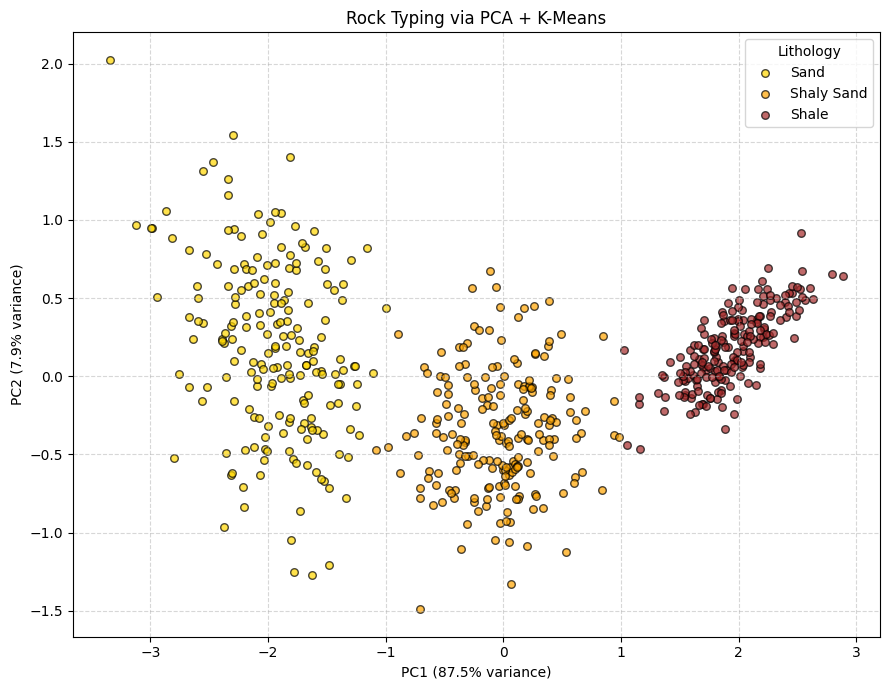

PCA explains 95.4% of total variance with 2 components.


In [2]:
# ----------------------------
# Step 1: Generate & Save Data
# ----------------------------
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

# ----------------------------
# Step 2: Read Data from CSV
# ----------------------------
df = pd.read_csv('synthetic_well_logs.csv')
X = df[['GR', 'RES', 'POR']].values

# ----------------------------
# Step 3: Standardize + PCA + K-Means
# ----------------------------
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(X_pca)

# ----------------------------
# Step 4: Map clusters to lithology names
# ----------------------------
# Compute mean PC coordinates for each cluster
cluster_centers = kmeans.cluster_centers_
cluster_ids = np.unique(clusters)

# Get average original features per cluster to infer lithology
lith_mapping = {}
for i in cluster_ids:
    mask = clusters == i
    avg_gr = df.loc[mask, 'GR'].mean()
    # Use GR as proxy: low GR → Sand, medium → Shaly Sand, high → Shale
    if avg_gr < 70:
        lith_mapping[i] = 'Sand'
    elif avg_gr < 110:
        lith_mapping[i] = 'Shaly Sand'
    else:
        lith_mapping[i] = 'Shale'

# Assign lithology names to each point
predicted_lith = [lith_mapping[clust] for clust in clusters]

# Create a color map for consistent coloring
lith_order = ['Sand', 'Shaly Sand', 'Shale']
color_map = {'Sand': 'gold', 'Shaly Sand': 'orange', 'Shale': 'brown'}
colors = [color_map[lith] for lith in predicted_lith]

# ----------------------------
# Step 5: Plot with lithology names
# ----------------------------
plt.figure(figsize=(9, 7))

for lith in lith_order:
    mask = np.array(predicted_lith) == lith
    plt.scatter(X_pca[mask, 0], X_pca[mask, 1],
                label=lith, color=color_map[lith], alpha=0.7, edgecolor='k', s=30)

plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} variance)')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} variance)')
plt.title('Rock Typing via PCA + K-Means')
plt.legend(title="Lithology")
plt.grid(True, ls='--', alpha=0.5)
plt.tight_layout()
plt.savefig('pca_kmeans_rocktypes.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"PCA explains {pca.explained_variance_ratio_.sum():.1%} of total variance with 2 components.")